In this notebook, we will show how to compare different GP libraries to give the same loss for a simple GP regression problem.

In [1]:
import numpy as np
import GPy
import gpytorch
import torch


from jax.config import config
import jax.numpy as jnp
import optax as ox
import jax.random as jr

from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)



# Generate the 1D regression dataset
np.random.seed(0)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(2 * np.pi * X).ravel() + 0.05 * np.random.randn(N)

# Create the GPy model
kernel = GPy.kern.RBF(input_dim=1, lengthscale=1)
gpy_model = GPy.models.GPRegression(X, y.reshape(-1, 1), kernel)

# Evaluate the GPy loss
gpy_loss = -gpy_model.log_likelihood()

# Create the gpytorch model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the likelihood and model
likelihood_gpytorch = gpytorch.likelihoods.GaussianLikelihood()

# Set likelihood noise to the GPy value
likelihood_gpytorch.noise = gpy_model.likelihood.variance[0]

gpytorch_model = GPRegressionModel(torch.from_numpy(X).float(), torch.from_numpy(y).float(), likelihood_gpytorch)

# Set the kernel parameters to the GPy values
gpytorch_model.covar_module.base_kernel.lengthscale = gpy_model.kern.lengthscale[0]
gpytorch_model.covar_module.outputscale = gpy_model.kern.variance[0]

# Confirm that the GPy and gpytorch models have the same parameters
assert gpy_model.kern.lengthscale[0] == gpytorch_model.covar_module.base_kernel.lengthscale.item()
assert gpy_model.kern.variance[0] == gpytorch_model.covar_module.outputscale.item()
assert gpy_model.likelihood.variance[0] == gpytorch_model.likelihood.noise.item()

# Find the gpytorch loss
output = gpytorch_model(torch.from_numpy(X).float())
# MLL
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_gpytorch, gpytorch_model)

# Find the gpytorch loss
gpytorch_loss = -mll(output, torch.from_numpy(y).float())

# Print the losses
print('GPy loss: {}'.format(gpy_loss))
# We multiply by N because the gpytorch loss is the average loss per data point
print('gpytorch loss: {}'.format(gpytorch_loss.item()*N))

GPy loss: 106.72974515800342
gpytorch loss: 106.72974586486816


In [2]:
# Set the GPy model parameters to the GPJax model
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)

likelihood = gpx.Gaussian(num_datapoints=N)

# Set the likelihood variance to the GPy model
likelihood.variance = gpy_model.likelihood.variance[0]

In [3]:
parameter_state = gpx.initialise(prior, key)
posterior = prior * likelihood

# Set the kernel parameters to the GPy values
parameter_state = gpx.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([gpy_model.kern.lengthscale[0]]), "variance": jnp.array([gpy_model.kern.variance[0]])}
)

In [4]:
params, trainable, bijectors = parameter_state.unpack()

In [5]:
params

{'kernel': {'lengthscale': Array([1.], dtype=float64),
  'variance': Array([1.], dtype=float64)},
 'mean_function': {},
 'likelihood': {'obs_noise': Array([1.], dtype=float64)}}

In [6]:
X.shape, y.shape

((100, 1), (100,))

In [7]:
# Create GPJax dataset object
ds = Dataset(X=X, y=y.reshape(-1, 1))
negative_mll = posterior.marginal_log_likelihood(ds, negative=True)
negative_mll(params)

Array(106.72978404, dtype=float64)

In [8]:
# Now train both the GPy, gpytorch and GPJax models and compare the losses and parameters
# Use multiple restarts to find the best GPy model
# Initialize the GPy model and then use the same hyperparameters in the gpytorch model
# Use same optimizer and training iterations for both models

# Train the GPy model with multiple restarts and 100 iterations
gpy_model.optimize(max_iters=100)

# Train the gpytorch model
gpytorch_model.train()
likelihood_gpytorch.train()

# Train using Adam
optimizer = torch.optim.Adam(gpytorch_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_gpytorch, gpytorch_model)

training_iter = 100

# Training loop

for i in range(training_iter):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = gpytorch_model(torch.from_numpy(X).float())
    # Calc loss and backprop gradients
    loss = -mll(output, torch.from_numpy(y).float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

    

# Print the GPy and gpytorch losses

print('GPy loss: {}'.format(gpy_model.log_likelihood()))
print('gpytorch loss: {}'.format(-mll(output, torch.from_numpy(y).float()).item()))




Iter 1/100 - Loss: 1.067
Iter 2/100 - Loss: 1.040
Iter 3/100 - Loss: 1.012
Iter 4/100 - Loss: 0.983
Iter 5/100 - Loss: 0.954
Iter 6/100 - Loss: 0.923
Iter 7/100 - Loss: 0.889
Iter 8/100 - Loss: 0.853
Iter 9/100 - Loss: 0.811
Iter 10/100 - Loss: 0.765
Iter 11/100 - Loss: 0.713
Iter 12/100 - Loss: 0.659
Iter 13/100 - Loss: 0.605
Iter 14/100 - Loss: 0.553
Iter 15/100 - Loss: 0.505
Iter 16/100 - Loss: 0.460
Iter 17/100 - Loss: 0.417
Iter 18/100 - Loss: 0.375
Iter 19/100 - Loss: 0.334
Iter 20/100 - Loss: 0.291
Iter 21/100 - Loss: 0.248
Iter 22/100 - Loss: 0.204
Iter 23/100 - Loss: 0.158
Iter 24/100 - Loss: 0.112
Iter 25/100 - Loss: 0.064
Iter 26/100 - Loss: 0.016
Iter 27/100 - Loss: -0.033
Iter 28/100 - Loss: -0.083
Iter 29/100 - Loss: -0.134
Iter 30/100 - Loss: -0.185
Iter 31/100 - Loss: -0.236
Iter 32/100 - Loss: -0.287
Iter 33/100 - Loss: -0.338
Iter 34/100 - Loss: -0.388
Iter 35/100 - Loss: -0.437
Iter 36/100 - Loss: -0.486
Iter 37/100 - Loss: -0.533
Iter 38/100 - Loss: -0.579
Iter 39/1

In [9]:

# Train the GPJax model
# Use the same optimizer and training iterations as GPy and gpytorch

# Create the GPJax model
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
learned_params, training_history = inference_state.unpack()

pp.pprint(learned_params)

{   'kernel': {   'lengthscale': Array([0.3214367], dtype=float64),
                  'variance': Array([1.2552691], dtype=float64)},
    'likelihood': {'obs_noise': Array([0.0072137], dtype=float64)},
    'mean_function': {}}


In [11]:
# Print the learnt GPy parameters
print('GPy lengthscale: {}'.format(gpy_model.kern.lengthscale[0]))
print('GPy variance: {}'.format(gpy_model.kern.variance[0]))
print('GPy noise: {}'.format(gpy_model.likelihood.variance[0]))


GPy lengthscale: 0.3498749924084259
GPy variance: 1.736410964793945
GPy noise: 0.002260382918441148


In [12]:
# Print GPytorch parameters
print('gpytorch lengthscale: {}'.format(gpytorch_model.covar_module.base_kernel.lengthscale.item()))
print('gpytorch variance: {}'.format(gpytorch_model.covar_module.outputscale.item()))
print('gpytorch noise: {}'.format(gpytorch_model.likelihood.noise.item()))

gpytorch lengthscale: 0.3494666516780853
gpytorch variance: 1.6869200468063354
gpytorch noise: 0.0023756392765790224


 /Users/nipun/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?


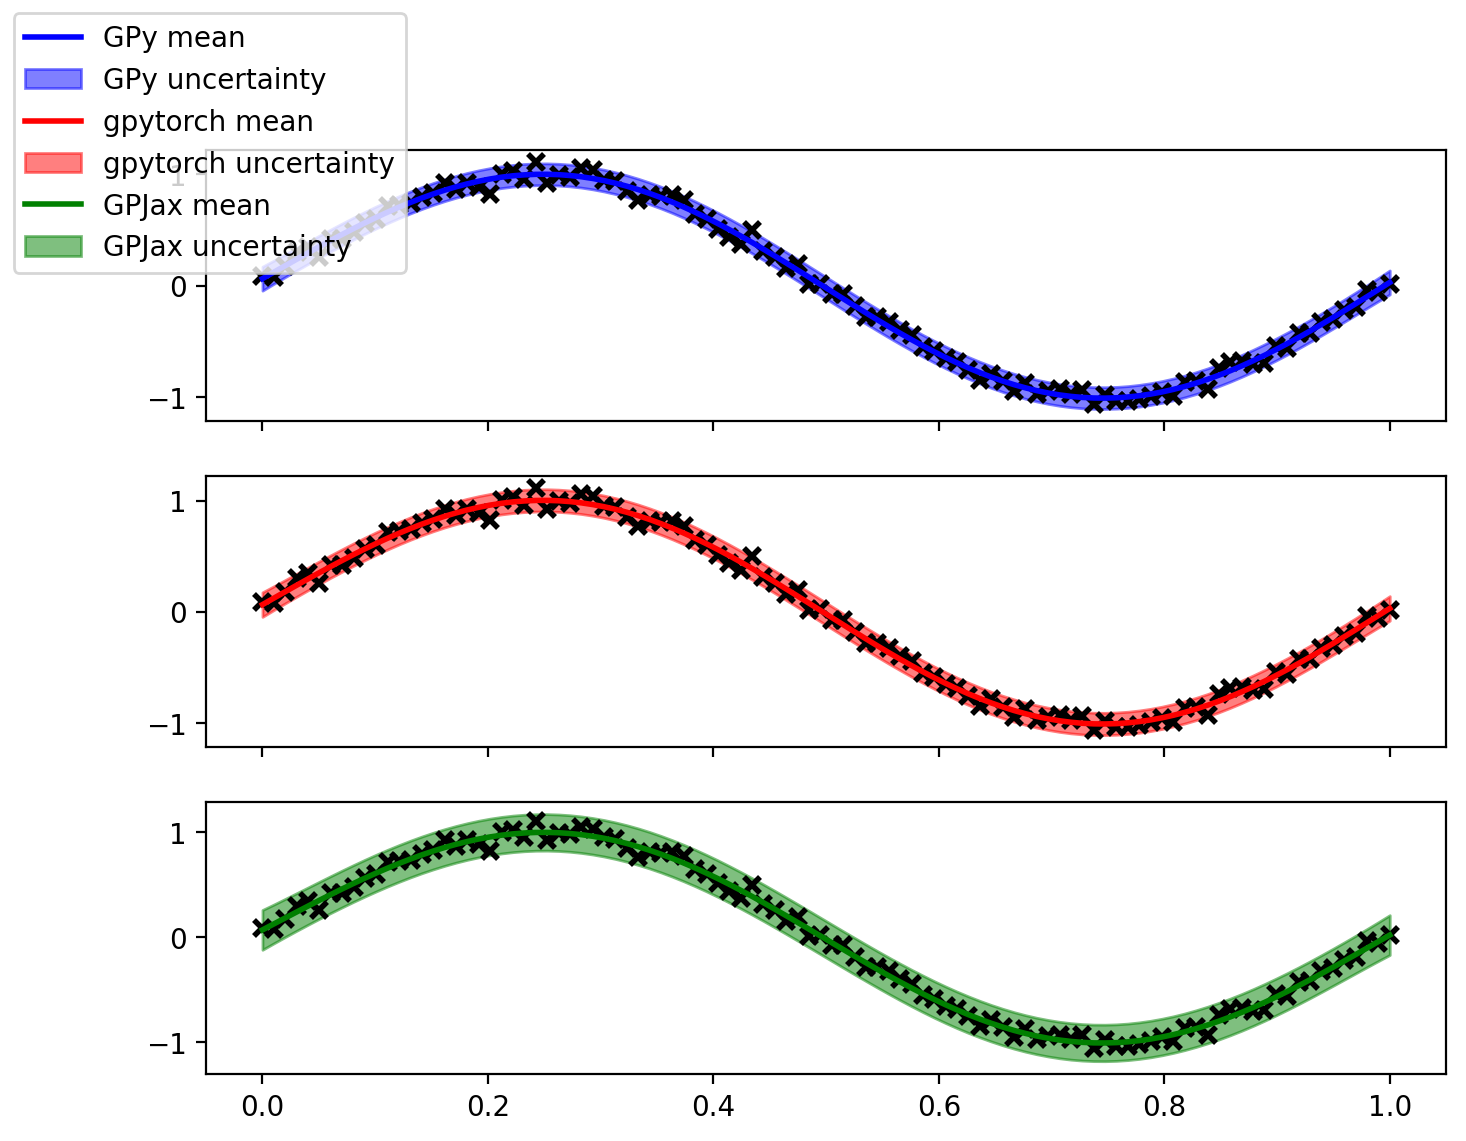

In [13]:
# plot the GPy, gpytorch and gpjax model predictions in 3 subplots sharing the x axis and having same ylim
import matplotlib.pyplot as plt
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

# Get the GPy predictions
gpy_mean, gpy_var = gpy_model.predict(X)

# Get the gpytorch predictions
gpytorch_model.eval()
likelihood_gpytorch.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood_gpytorch(gpytorch_model(torch.from_numpy(X).float()))

# Get the GPJax predictions
latent_dist = posterior(learned_params, ds)(X)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

axs[0].plot(X, y, 'kx', mew=2)
axs[0].plot(X, gpy_mean, 'b', lw=2, label='GPy mean')

axs[1].plot(X, y, 'kx', mew=2)

axs[1].plot(X, observed_pred.mean.numpy(), 'r', lw=2, label='gpytorch mean')
axs[2].plot(X, y, 'kx', mew=2)

axs[2].plot(X, predictive_mean, 'g', lw=2, label='GPJax mean')




axs[0].fill_between(X.flatten(), gpy_mean.flatten() - 2 * np.sqrt(gpy_var.flatten()), gpy_mean.flatten() + 2 * np.sqrt(gpy_var.flatten()), alpha=0.5, color='blue', label='GPy uncertainty')

# Get the lower and upper confidence bounds for the gpytorch model
lower, upper = observed_pred.confidence_region()
axs[1].fill_between(X.flatten(), lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5, color='red', label='gpytorch uncertainty')

axs[2].fill_between(X.flatten(), predictive_mean.flatten() - 2 * predictive_std.flatten(), predictive_mean.flatten() + 2 * predictive_std.flatten(), alpha=0.5, color='green', label='GPJax uncertainty')
fig.legend(loc='upper left')
